In [2]:
#pip install pyldavis

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import tqdm



In [4]:
import scipy

In [5]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, Phrases
from gensim.models.phrases import Phraser

from gensim.models import LdaMulticore, CoherenceModel
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import itertools
from networkx.algorithms import community
import community as community_louvain


In [6]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seegervanhengel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/seegervanhengel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/seegervanhengel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
#load data from web of science
data = pd.read_csv('dataset_2105_merged.csv')
print(len(data))
data = data.dropna(subset=['Abstract_scopus'])
print(len(data))




244
244


In [9]:
#extract all sentences from the abstracts
all_sentences = []
for abstract in data['Abstract_scopus']:
    sentences = sent_tokenize(abstract)
    all_sentences.extend(sentences)

print(f"Total number of sentences extracted: {len(all_sentences)}")
print(all_sentences[:5])  


Total number of sentences extracted: 2257
["Trustworthy Artificial Intelligence (AI) is based on seven technical requirements sustained over three main pillars that should be met throughout the system's entire life cycle: it should be (1) lawful, (2) ethical, and (3) robust, both from a technical and a social perspective.", "However, attaining truly trustworthy AI concerns a wider vision that comprises the trustworthiness of all processes and actors that are part of the system's life cycle, and considers previous aspects from different lenses.", 'A more holistic vision contemplates four essential axes: the global principles for ethical use and development of AI-based systems, a philosophical take on AI ethics, a risk-based approach to AI regulation, and the mentioned pillars and requirements.', 'The seven requirements (human agency and oversight; robustness and safety; privacy and data governance; transparency; diversity, non-discrimination and fairness; societal and environmental well

In [10]:
#ereate formula to preprocess the data
def preprocess_data(sentences):
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {'artificial', 'intelligence', 'ai', 'responsible', 'ieee'}
    stop_words.update(custom_stopwords)
    
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    
    processed_sentences = []
    for sentence in sentences:
        sentence = sentence.lower()
        tokens = tokenizer.tokenize(sentence)
        tokens = [token for token in tokens if not token.isdigit()]
        tokens = [token for token in tokens if len(token) > 2 and token not in stop_words]
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        processed_sentences.append(tokens)
    
    bigram = Phrases(processed_sentences, min_count=10, threshold=30)  
    trigram = Phrases(bigram[processed_sentences], min_count=10, threshold=30)

    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)

    processed_sentences = [trigram_mod[bigram_mod[sentence]] for sentence in processed_sentences]
    
    return processed_sentences


In [11]:
#preprocess the data
processed_data = preprocess_data(all_sentences)

In [12]:
#inspect processed data
print(processed_data)

[['trustworthy', 'based', 'seven', 'technical', 'requirement', 'sustained', 'three', 'main', 'pillar', 'met', 'throughout', 'system', 'entire', 'life', 'cycle', 'lawful', 'ethical', 'robust', 'technical', 'social', 'perspective'], ['however', 'attaining', 'truly', 'trustworthy', 'concern', 'wider', 'vision', 'comprises', 'trustworthiness', 'process', 'actor', 'part', 'system', 'life', 'cycle', 'considers', 'previous', 'aspect', 'different', 'lens'], ['holistic', 'vision', 'contemplates', 'four', 'essential', 'ax', 'global', 'principle', 'ethical', 'use', 'development', 'based', 'system', 'philosophical', 'take', 'ethic', 'risk', 'based', 'approach', 'regulation', 'mentioned', 'pillar', 'requirement'], ['seven', 'requirement', 'human', 'agency', 'oversight', 'robustness', 'safety', 'privacy', 'data', 'governance', 'transparency', 'diversity', 'non', 'discrimination', 'fairness', 'societal', 'environmental', 'wellbeing', 'accountability', 'analyzed', 'triple', 'perspective', 'requirement

In [13]:
#create dictionary
dictionary = corpora.Dictionary(processed_data)
print('Number of unique words in initital documents:', len(dictionary))

#filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))



Number of unique words in initital documents: 5055
Number of unique words after removing rare and common words: 726


In [14]:
#create corpus
texts = processed_data

#term Document Frequency
corpus = [dictionary.doc2bow(text) for text in texts]



In [15]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 726
Number of documents: 2257


In [16]:
#create formula to compute coherence values
def compute_coherence_values(corpus, dictionary, k, alpha, eta, texts, passes, chunksize, random_state):
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=random_state,
        chunksize=chunksize,
        passes=passes,
        alpha=alpha,
        eta=eta,
    )
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_value = coherence_model_lda.get_coherence()
    
    return lda_model, coherence_value


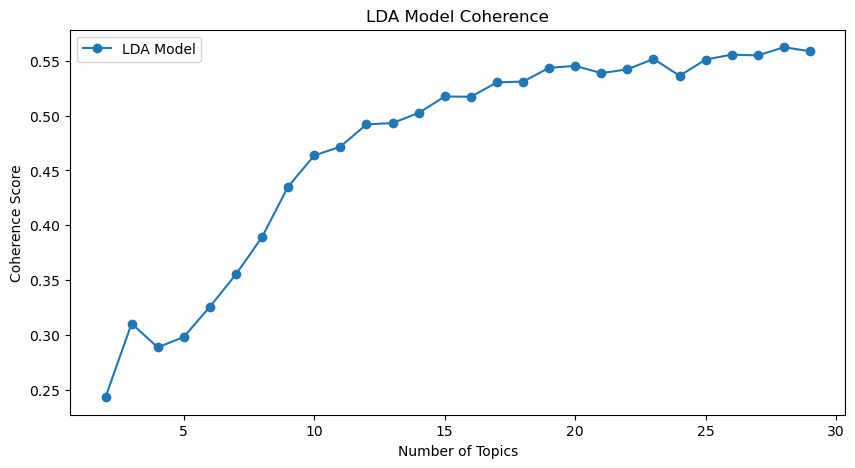

In [17]:
#parameters for the LDA models
limit = 30
start = 2
step = 1
passes = 20
chunksize = 50
random_state = 42
model_list_lda = []
coherence_values_lda = []

#compute coherence values for different number of topics
for num_topics in range(start, limit, step):
    alpha = 50.0 / num_topics
    eta = 0.01
    lda_model, coherence_value = compute_coherence_values(corpus, dictionary, num_topics, alpha, eta, 
                                                          processed_data, passes, chunksize, random_state)
    coherence_values_lda.append(coherence_value)
    model_list_lda.append(lda_model)

#plot
plt.figure(figsize=(10, 5))
plt.plot(range(start, limit, step), coherence_values_lda, marker='o', label='LDA Model')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("LDA Model Coherence")
plt.legend()
plt.savefig('model_lda_coherence_score_small_sentence.png')
plt.show()


In [18]:
#show list of coherence values
x = range(start, limit, step)
for m, cv in zip(x, coherence_values_lda):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2433
Num Topics = 3  has Coherence Value of 0.3105
Num Topics = 4  has Coherence Value of 0.2888
Num Topics = 5  has Coherence Value of 0.2982
Num Topics = 6  has Coherence Value of 0.3258
Num Topics = 7  has Coherence Value of 0.3553
Num Topics = 8  has Coherence Value of 0.3893
Num Topics = 9  has Coherence Value of 0.4353
Num Topics = 10  has Coherence Value of 0.4636
Num Topics = 11  has Coherence Value of 0.4716
Num Topics = 12  has Coherence Value of 0.4919
Num Topics = 13  has Coherence Value of 0.4932
Num Topics = 14  has Coherence Value of 0.5023
Num Topics = 15  has Coherence Value of 0.5174
Num Topics = 16  has Coherence Value of 0.5171
Num Topics = 17  has Coherence Value of 0.5302
Num Topics = 18  has Coherence Value of 0.531
Num Topics = 19  has Coherence Value of 0.5435
Num Topics = 20  has Coherence Value of 0.5453
Num Topics = 21  has Coherence Value of 0.5387
Num Topics = 22  has Coherence Value of 0.5421
Num Topics = 23  has C

In [19]:
#set number of topics for final model
num_topics = 5
alpha = 50.0 / num_topics
eta = 0.01
limit = 30
start = 2
step = 1
passes = 20
chunksize = 50
random_state = 42

#build final LDA model with the parameters
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=random_state,
    chunksize=chunksize,
    passes=passes,
    alpha=alpha,
    eta=eta)



In [20]:
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)

Coherence Score: 0.29819545642788886


In [21]:
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.039149  0.186114       1        1  20.130503
4      0.261269 -0.347121       2        1  20.045961
0     -0.275526 -0.121094       3        1  19.981008
2     -0.239292  0.023014       4        1  19.956428
3      0.214400  0.259087       5        1  19.886099, topic_info=            Term        Freq       Total Category  logprob  loglift
34          data  742.000000  742.000000  Default  30.0000  30.0000
186    algorithm  451.000000  451.000000  Default  29.0000  29.0000
202     research  416.000000  416.000000  Default  28.0000  28.0000
39         human  410.000000  410.000000  Default  27.0000  27.0000
91     framework  405.000000  405.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
117       policy   60.688406   60.777490   Topic5  -4.2552   1.6137
51      auditing   46.101409   46.190493   Topic5  -4.5301   1.6132
173          way   45.681144   45.770228   Topic5  -4.5393   1.6132
144    promising   44.801823   44.890907   Topic5  -4.5587   1.6132
118  contributes   37.338764   37.427848   Topic5  -4.7409   1.6128

[187 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
145       1  1.000152          access
32        2  1.001770  accountability
224       1  0.998531          across
207       2  0.999985      addressing
186       3  1.000369       algorithm
...     ...       ...             ...
212       5  1.002071         whether
239       2  0.997686          within
64        5  0.994080            work
240       1  0.999872             xai
86        4  0.992023             yet

[161 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 3, 4])

## Explore topics

In [22]:
#define formula to extract lists of topics including frequencies
def explore_topic(lda_model, topic_number, topn, output=True):
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [23]:
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

data                 0.154
algorithm            0.105
system               0.094
patient              0.043
existing             0.038
healthcare           0.037
risk                 0.034
value                0.033
key                  0.032
well                 0.030
Topic 1 |---------------------

research             0.096
ethical              0.082
right                0.053
future               0.047
information          0.043
design               0.043
technique            0.039
user                 0.039
use                  0.035
xai                  0.034
Topic 2 |---------------------

human                0.096
bias                 0.088
based                0.079
model                0.078
application          0.066
approach             0.061
however              0.051
technical            0.037
subject              0.035
use                  0.032
Topic 3 |---------------------

framework            0.095
tec

In [24]:
#create formula to get the distribution of topics per document
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])], ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=processed_data)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


In [25]:
#run the pre-defined formula
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().rename_axis('Dominant_Topic').reset_index(name='Num_Documents')
topic_counts['Perc_Documents'] = round(topic_counts['Num_Documents'] / topic_counts['Num_Documents'].sum(), 4)

topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
df_dominant_topics = pd.merge(topic_num_keywords, topic_counts, on='Dominant_Topic', how='left')

#display the resulting DataFrame
df_dominant_topics.sort_values(by=['Num_Documents'], ascending = [False])
df_dominant_topics_sorted = df_dominant_topics.sort_values(by=['Num_Documents'], ascending=[False])
df_dominant_topics_sorted.to_excel('dominant_topics.xlsx', index=False)
df_dominant_topics_sorted


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
4,0,"data, algorithm, system, patient, existing, he...",476,0.2109
1,3,"framework, technology, study, need, developmen...",466,0.2065
3,1,"research, ethical, right, future, information,...",452,0.2003
2,4,"fairness, challenge, transparency, may, privac...",434,0.1923
0,2,"human, bias, based, model, application, approa...",429,0.1901


## Plotting word co-occurrences

This includes trials of potting the network graph in Python


In [26]:

num_topics = lda_model.num_topics
top_words_per_topic = []
for t in range(num_topics):
    top_words = lda_model.show_topic(t, topn=10)  
    top_words_per_topic.extend([(t, w[0], w[1]) for w in top_words])

In [27]:
print(num_topics)

5


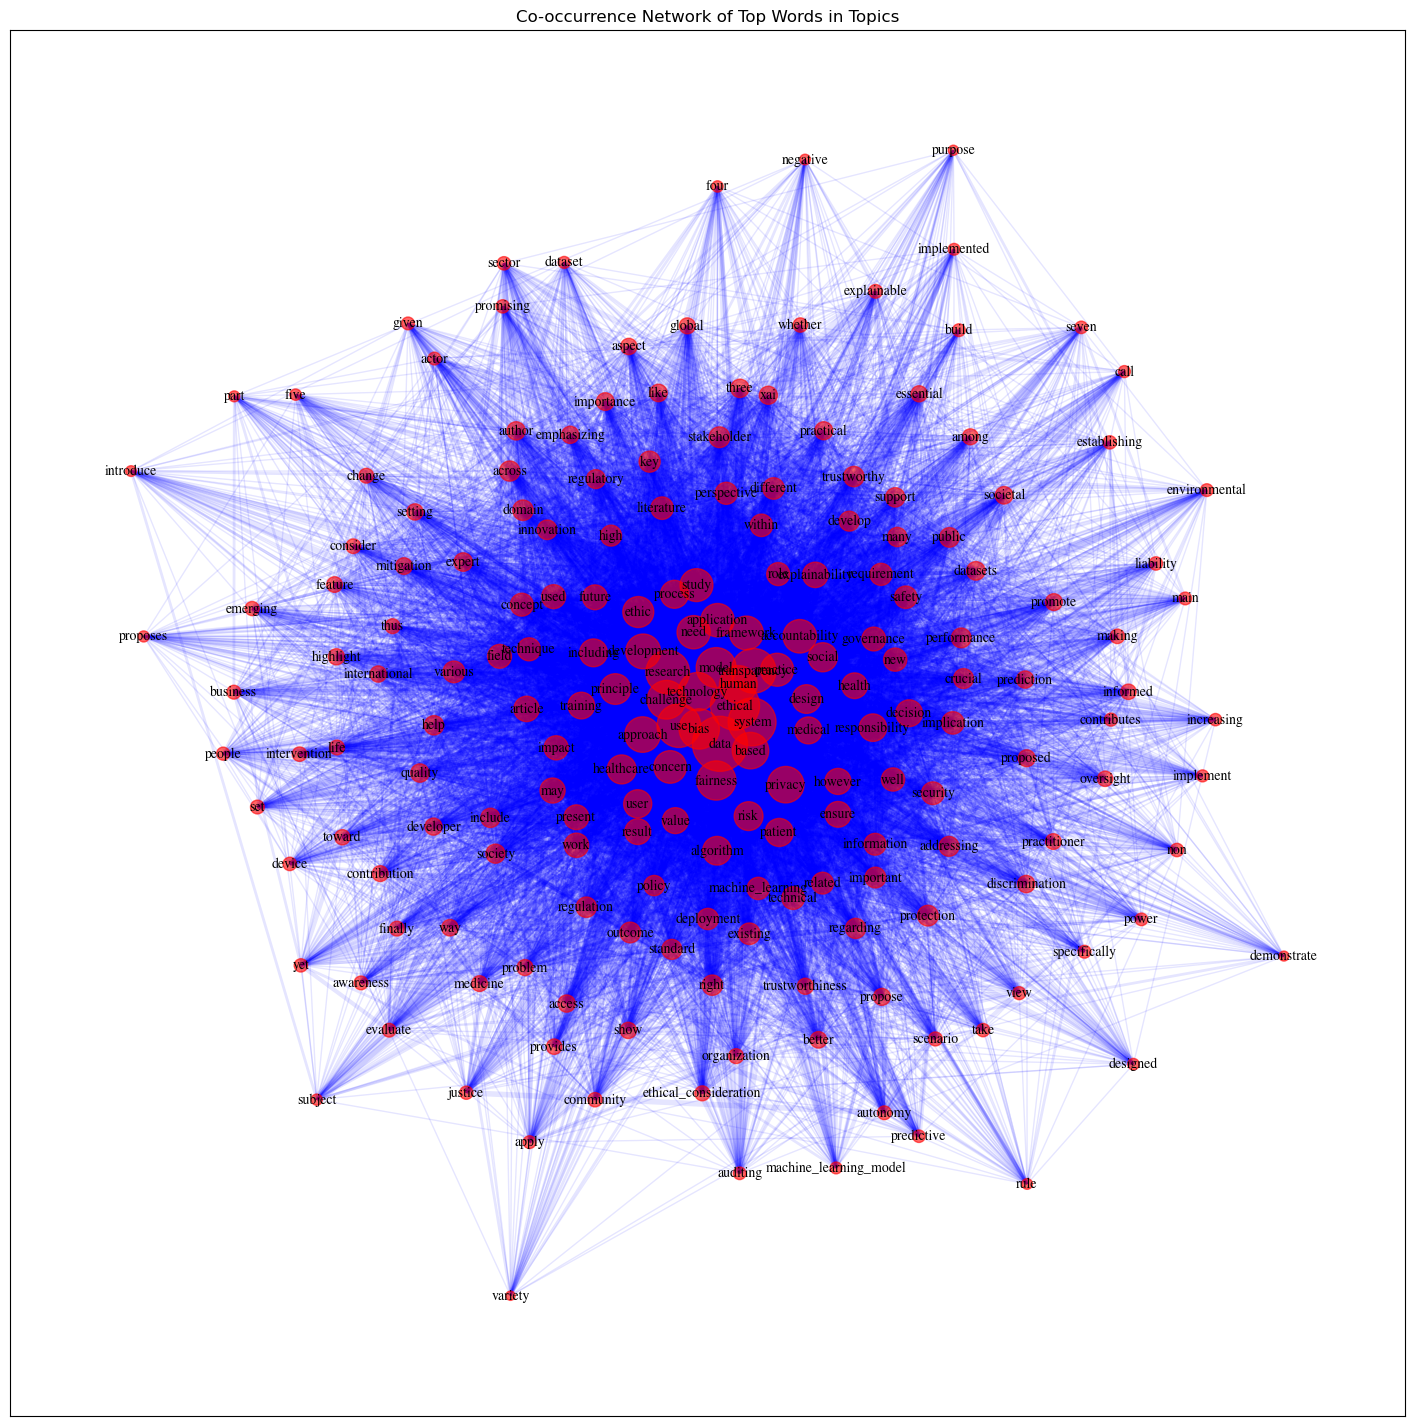

In [28]:
#extract top words from each topic
top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words = [word for word, prob in lda_model.show_topic(t, topn=40)]
    top_words_per_topic.extend(top_words)

top_words = list(set(top_words_per_topic))

#count co-occurrences only for top words
co_occurrences = Counter()
for words in texts:
    filtered_words = [word for word in words if word in top_words]
    for pair in itertools.combinations(sorted(set(filtered_words)), 2):
        co_occurrences[pair] += 1

#create a node file
nodes = list(set(top_words))
with open('nodes_large.txt', 'w') as f:
    f.write("id\tlabel\n")
    for i, node in enumerate(nodes):
        f.write(f"{i}\t{node}\n")
        
#create an edge file
with open('edges_large.txt', 'w') as f:
    f.write("source\ttarget\tweight\n")
    for (word1, word2), weight in co_occurrences.items():
        if word1 in nodes and word2 in nodes:
            f.write(f"{nodes.index(word1)}\t{nodes.index(word2)}\t{weight}\n")        

#create the graph
G = nx.Graph()
for (word1, word2), weight in co_occurrences.items():
    G.add_edge(word1, word2, weight=weight)

#set node size proportional to the degree of the node
degrees = dict(G.degree(weight='weight'))
nx.set_node_attributes(G, degrees, 'size')

#visualize the graph
pos = nx.spring_layout(G, k=0.75, iterations=100)
node_sizes = [degrees[node] for node in G]
edge_widths = [G[u][v]['weight'] for u, v in G.edges()]

plt.figure(figsize=(18, 18))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='red', alpha=0.6)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.1, edge_color='blue')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='times', font_weight = 'bold')

plt.title('Co-occurrence Network of Top Words in Topics')
plt.savefig('co_occurrence_network_small_sentence_large.png')
plt.show()


In [29]:
#count co-occurrences only for top words
co_occurrences = Counter()
for words in texts:
    filtered_words = [word for word in words if word in top_words]
    for pair in itertools.combinations(sorted(set(filtered_words)), 2):
        co_occurrences[pair] += 1

In [30]:
#load node and edge data
nodes = pd.read_csv('nodes_large.txt', sep='\t')
edges = pd.read_csv('edges_large.txt', sep='\t')

#create a NetworkX graph
G = nx.Graph()

#add nodes
for index, row in nodes.iterrows():
    G.add_node(row['id'], label=row['label'])

#add edges
for index, row in edges.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

In [31]:
#calculate node Degree
degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, 'degree')

In [32]:
#calculate degree centrality
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')

In [33]:
#calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')

In [34]:
#detect communities using the Louvain method
partition = community_louvain.best_partition(G)

#add modularity to nodes
for node, com in partition.items():
    G.nodes[node]['modularity_class'] = com

#convert dictionary for modularity calculation
partition_sets = [set() for _ in range(max(partition.values()) + 1)]
for node, com in partition.items():
    partition_sets[com].add(node)

#calculate modularity
modularity = community.modularity(G, partition_sets)
print(f'Modularity: {modularity}')

Modularity: 0.08208350192423852


In [35]:
#create a DataFrame to store metrics
metrics_df = pd.DataFrame({
    'node': list(G.nodes()),
    'label': [G.nodes[n]['label'] for n in G.nodes()],
    'degree': [G.nodes[n]['degree'] for n in G.nodes()],
    'degree_centrality': [G.nodes[n]['degree_centrality'] for n in G.nodes()],
    'betweenness_centrality': [G.nodes[n]['betweenness_centrality'] for n in G.nodes()]
})

print(metrics_df)
metrics_df.to_csv('network_metrics.csv', index=False)

     node           label  degree  degree_centrality  betweenness_centrality
0       0           three      96           0.487310                0.001530
1       1     development     160           0.812183                0.006626
2       2         process     150           0.761421                0.005866
3       3         include     103           0.522843                0.001790
4       4       regarding     102           0.517766                0.001925
..    ...             ...     ...                ...                     ...
193   193        standard     104           0.527919                0.002031
194   194          author      92           0.467005                0.001540
195   195  responsibility     128           0.649746                0.003472
196   196        datasets      96           0.487310                0.001696
197   197         promote      84           0.426396                0.000875

[198 rows x 5 columns]


In [36]:
### show top 10 words based on degree
top_10_degree = metrics_df.sort_values(by='degree', ascending=False).head(10)
print("Top 10 words based on degree:")
print(top_10_degree)

#show top 10 words based on degree centrality
top_10_degree_centrality = metrics_df.sort_values(by='degree_centrality', ascending=False).head(10)
print("Top 10 words based on degree centrality:")
print(top_10_degree_centrality)

#show top 10 words based on betweenness centrality
top_10_betweenness_centrality = metrics_df.sort_values(by='betweenness_centrality', ascending=False).head(10)
print("Top 10 words based on betweenness centrality:")
print(top_10_betweenness_centrality)


Top 10 words based on degree:
     node         label  degree  degree_centrality  betweenness_centrality
110   110          data     190           0.964467                0.011592
18     18        system     187           0.949239                0.011153
160   160           use     182           0.923858                0.010141
63     63       ethical     181           0.918782                0.009955
121   121      research     181           0.918782                0.009930
62     62  transparency     177           0.898477                0.009035
163   163         model     177           0.898477                0.009564
65     65         human     172           0.873096                0.008701
192   192    technology     172           0.873096                0.008230
158   158          bias     172           0.873096                0.008353
Top 10 words based on degree centrality:
     node         label  degree  degree_centrality  betweenness_centrality
110   110          data     1